In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('../../src')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from losses import _reconstruction_loss
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p, load_dataloader_and_pretrained_model
from captum.attr import *

# trim modules
sys.path.append('../../lib/trim')
from trim import TrimModel

# wt modules
from wavelet_transform import Wavelet_Transform, DTCWT_Mask, tuple_Attributer, create_images_high_attrs, compute_tuple_dim
import pywt

## load data and model

In [2]:
# get dataloader and model
train_loader, model = load_dataloader_and_pretrained_model(p)

## set up wavelet transform and trim model

In [3]:
# pywt.wavelist()

In [68]:
# wavelet transform
wt1 = Wavelet_Transform(wt_type='DWT', J=5, wave='db3')
wt2 = Wavelet_Transform(wt_type='DWT', J=5, wave='bior2.2')
# wt2 = Wavelet_Transform(wt_type='DTCWT', J=5)

# prepend transformation onto network
mt1 = TrimModel(model, wt1.inverse)
mt2 = TrimModel(model, wt2.inverse)

# input
torch.manual_seed(50)
im = iter(train_loader).next()[0][0:1].to(device)
im.requires_grad = True

# wavelet transform
t1 = wt1(im)
t2 = wt2(im)
tot_dim1 = compute_tuple_dim(t1)
tot_dim2 = compute_tuple_dim(t2)
print(tot_dim1, tot_dim2)

# interp score
# attr_methods = 'InputXGradient'
attr_methods = 'IntegratedGradient'
attributer1 = tuple_Attributer(mt1, attr_methods=attr_methods)
attributer2 = tuple_Attributer(mt2, attr_methods=attr_methods)
attributions1 = attributer1(t1, target=1)
attributions2 = attributer2(t2, target=1)

69831 69831


## sort in decreasing order

In [69]:
# get images with high attributions
num_sp = 20
results1 = create_images_high_attrs(attributions1, t1, wt1.inverse, tot_dim1, num_sp)
results2 = create_images_high_attrs(attributions2, t2, wt2.inverse, tot_dim2, num_sp)

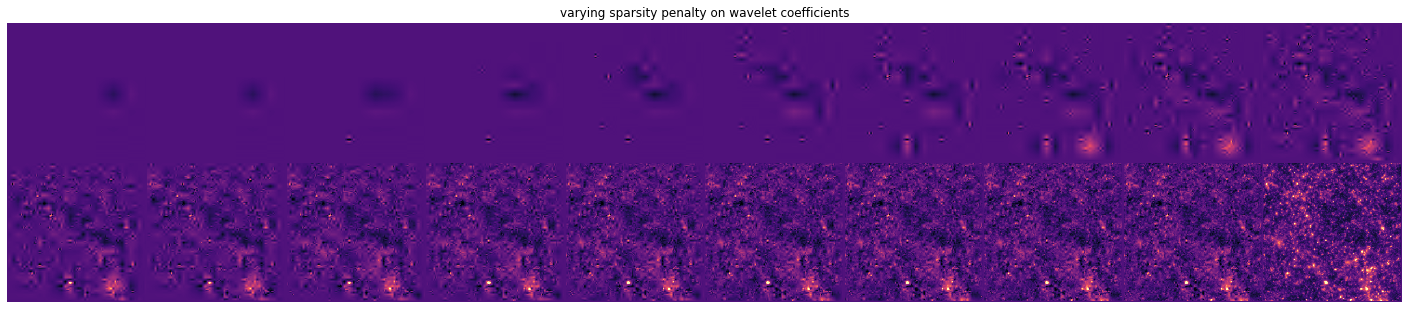

In [70]:
# viz
plt.figure(figsize=(25,25))
vmax=0.15
vmin=-0.05
n_row = 2
n_col = 10
d = 256 + 2
mosaic = np.zeros((d*n_row,d*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*d:(i+1)*d,j*d:(j+1)*d] = np.pad(results1[indx].squeeze().data.cpu().numpy(),(1,1),mode='constant')
        indx += 1
plt.title("varying sparsity penalty on wavelet coefficients")
plt.imshow(mosaic, cmap='magma', vmax=vmax, vmin=vmin)
plt.axis('off')    
plt.show()         
        

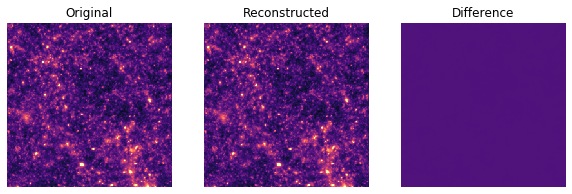

Recon Error: 2.29198099077621e-06


In [71]:
# check reconstruction quality
viz_im_r(im[0,0], results1[-1][0,0])
print('Recon Error:', torch.norm(im[0,0].cpu() - results1[-1][0,0]).item())

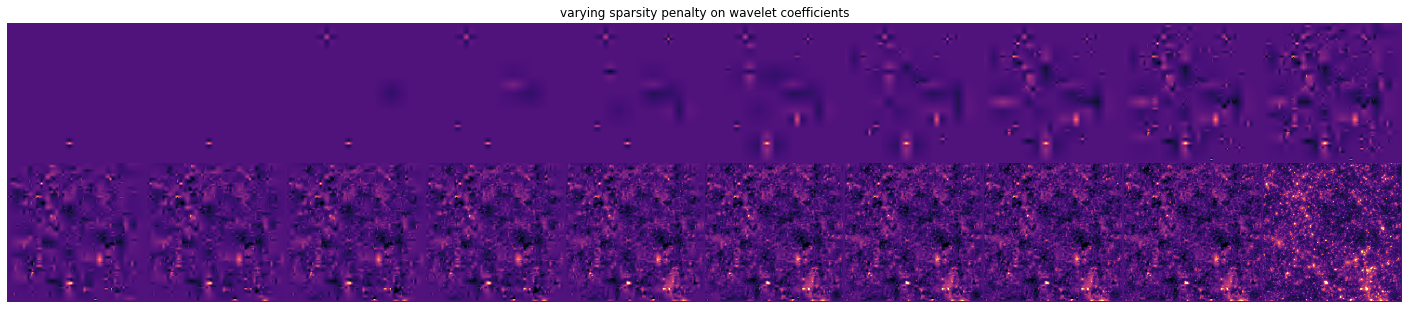

In [72]:
# viz
plt.figure(figsize=(25,25))
vmax=0.15
vmin=-0.05
n_row = 2
n_col = 10
d = 256 + 2
mosaic = np.zeros((d*n_row,d*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*d:(i+1)*d,j*d:(j+1)*d] = np.pad(results2[indx].squeeze().data.cpu().numpy(),(1,1),mode='constant')
        indx += 1
plt.title("varying sparsity penalty on wavelet coefficients")
plt.imshow(mosaic, cmap='magma', vmax=vmax, vmin=vmin)
plt.axis('off')    
plt.show()         
        

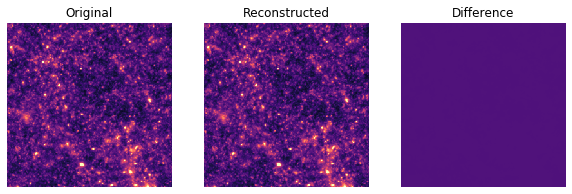

Recon Error: 2.7750506887969095e-06


In [73]:
# check reconstruction quality
viz_im_r(im[0,0], results2[-1][0,0])
print('Recon Error:', torch.norm(im[0,0].cpu() - results2[-1][0,0]).item())

In [74]:
corr_mat = []
for i in range(num_sp):
    corrs = []
    rec1 = results1[i]
    for j in range(num_sp):
        rec2 = results2[j]
        corrs.append(np.corrcoef(rec1.detach().numpy().reshape(-1), rec2.detach().numpy().reshape(-1))[0,1])
    corr_mat.append(np.array(corrs))
corr_mat = np.stack(corr_mat, axis=0)

In [75]:
for i in range(num_sp):
    print(np.argmax(corr_mat[i]), np.max(corr_mat[i]))

2 0.4549034334544195
2 0.4549034334736818
4 0.41951295474455186
4 0.4818469515951093
4 0.35816165720184917
4 0.4135650293688715
5 0.53522325612565
14 0.42914964452242266
14 0.4623556813655408
14 0.49689215167588363
14 0.5608166854991878
14 0.6019411821540307
15 0.6364319548089075
15 0.66476744023518
16 0.6925331446707762
18 0.7278981329591516
18 0.7514697439140824
18 0.7668472329491719
18 0.7726579357770248
19 0.9999999999999701
